This Jupyter Notebook is used for extracting data from multiple sources. The sources include trip data, occupancy data, and parking lot data. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import os
import folium
from pathlib import Path
import boto3

# import from src
os.chdir('../src')
from trips_data_retrieval import get_agg_trips_by_market, get_agg_trips
import inrix_data_science_utils.maps.quadkey as qkey

# set paths
data_path = Path('../data')

### Extracting Trips

In [2]:
# Change these as needed
# qk_list = ['02123003']  # seattle area
qk_list = ['021230032110033003', '021230032110033012', '021230032110033021', '021230032110033030']  # QFC North Bend
start_date = pd.to_datetime('2023-01-01 00:00:00')
end_date = pd.to_datetime('2023-01-30 00:01:00')
trip_type = 'dest'
filename_description = 'QFC_North_Bend'

# don't change these
start_year = str(start_date.year)
start_month = str(start_date.month).zfill(2)
start_day = str(start_date.day).zfill(2)
end_year = str(end_date.year)
end_month = str(end_date.month).zfill(2)
end_day = str(end_date.day).zfill(2)
out_filename = f'''trips_{start_year}-{start_month}-{start_day}_to_{
                end_year}-{end_month}-{end_day}{filename_description}.csv'''
out_file_path = data_path / out_filename
print('Will save the csv to ', out_file_path)
origin_qk = (trip_type == 'orig')

table_name = 'tripdata_na_restricted'
s3_tapp_data_dir = 'data-restricted'
s3_tapp_region = 'NA'

Will save the csv to  ..\data\trips_2023-01-01_to_2023-01-30QFC_North_Bend.csv


In [3]:
# if out_file_path not in the data folder, save it there
if not os.path.exists(out_file_path):
    df = get_agg_trips(
        agg_file_path = out_file_path,
        echo_query=True,
        table_name=table_name,
        start_date=start_date,
        end_date=end_date,
        qk_filter_list=qk_list,
        s3_tapp_data_dir=s3_tapp_data_dir,
        s3_tapp_region=s3_tapp_region,
        origin_qk=origin_qk,
    )
    print('Saved the csv to ', out_file_path)
else:
    df = pd.read_csv(out_file_path)

In [4]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])
display(df)

,year,month,day,hour,minute,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,count,trip_id,is_moving,date
0,2023,1,14,19,5,6,2123003210100112,2123003211003300,47.514280,-121.885120,47.493401,-121.781062,1,9ea8485484233efcc31c6c3d84185a9b,1,2023-01-14 19:05:06
1,2023,1,8,3,14,37,2123003211003213,2123003211003300,47.492525,-121.783959,47.493421,-121.781032,1,49b21595c355553c8583ee6eb42f0d4c,1,2023-01-08 03:14:37
2,2023,1,17,1,31,40,2123003032333233,2123003211003302,47.518027,-121.829146,47.493044,-121.781043,1,43e2157c11da1b4ea6e5fd4d632b48b5,1,2023-01-17 01:31:40
3,2023,1,2,3,14,45,2123003211031321,2123003211003300,47.474735,-121.736246,47.493170,-121.780872,1,22977f92951b5f961f91a40143175387,1,2023-01-02 03:14:45
4,2023,1,19,22,23,28,2123003211030032,2123003211003303,47.480184,-121.766035,47.492447,-121.780295,1,19096820ba29b906b6c7b3b3875421af,1,2023-01-19 22:23:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,2023,1,11,3,44,30,2123003211003033,2123003211003300,47.495470,-121.785699,47.493390,-121.781301,1,d60e02cb865dfb245af144e73e695d1f,1,2023-01-11 03:44:30
2240,2023,1,26,1,36,29,2123003211003212,2123003211003300,47.491927,-121.787866,47.493176,-121.780806,1,fd25fa019b4d7ab8ec811dfca96cc8e8,1,2023-01-26 01:36:29
2241,2023,1,16,5,48,28,2123003020223112,2123003211003303,47.648216,-122.305252,47.492958,-121.780427,1,c3531b2132e1f316b42944b83723d4db,1,2023-01-16 05:48:28
2242,2023,1,20,13,43,34,2123003211021130,2123003211003300,47.483331,-121.776155,47.493287,-121.780960,1,d6709610d545db98c72ae5f50476ba4a,1,2023-01-20 13:43:34


In [5]:
m = folium.Map(zoom_start=10)

N = 11
for i in range(0, df.shape[0], N):
    folium.CircleMarker(
        location=[
            df['end_lat'].values[i],
            df['end_lon'].values[i]
        ],
        color='red',
        radius=1
    ).add_to(m)
m.fit_bounds(m.get_bounds())

m

### Extract the 6 Flags Polygon Shapes

In [6]:
from polygon_retrieval import get_polygons

In [7]:
# Six Flags
brand_id = 'SG_BRAND_0dd52fbf1cd77fc38e06650435ada07d'
poly_file_name = data_path / 'six_flags_polygons.csv'

In [8]:
if not os.path.exists(poly_file_name):
    polygon_df = get_polygons(brand_id, format='df', echo_query=True)
    relevant_cols = ['location_name', 'top_category', 'sub_category', 'latitude', 'longitude', 'street_address', 'city', 'region', 'postal_code', 'open_hours',
                 'category_tags', 'polygon_wkt', 'polygon_class', 'enclosed', 'is_synthetic', 'includes_parking_lot', 'wkt_area_sq_meters', 'tz', 'year',
                 'month', 'pg_id', 'parking_wkt']
    polygon_df = polygon_df[relevant_cols]
    polygon_df.to_csv(poly_file_name, index=False)
else:
    polygon_df = pd.read_csv(poly_file_name)

In [9]:
# make a new df with just the unique latitude and longitude columns
store_locations_df = polygon_df[['latitude', 'longitude', 'street_address', 'city', 'region']].drop_duplicates()
display(store_locations_df)

,latitude,longitude,street_address,city,region
0,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY
53,42.369309,-87.935103,542 N State Route 21,Gurnee,IL
76,38.906271,-76.776467,13710 Central Ave,Bowie,MD
148,40.141007,-74.438164,1 Six Flags Blvd,Jackson,NJ
334,32.761690,-97.081166,1800 E Lamar Blvd,Arlington,TX
355,35.463453,-97.589371,3908 W Reno Ave,Oklahoma City,OK
359,42.927651,-78.385383,9993 Alleghany Rd,Corfu,NY
403,42.245289,-88.964116,7820 Cherryvale N Blvd,Cherry Valley,IL


In [10]:
six_flag_stores = folium.Map(zoom_start=15)
for i, row in store_locations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='blue',
        radius=4
    ).add_to(six_flag_stores)
six_flag_stores.fit_bounds(six_flag_stores.get_bounds())
six_flag_stores

#### Map the parking lots at each store

epsg:4326


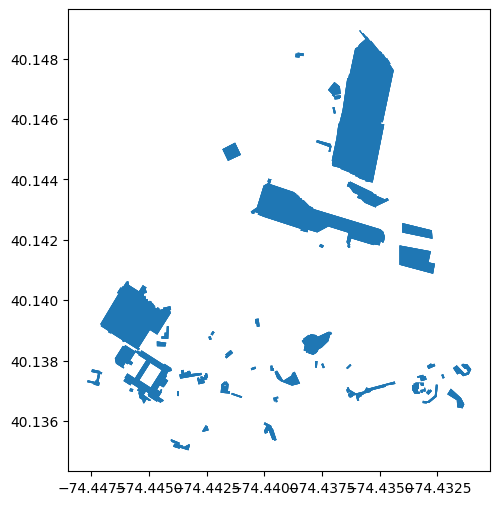

In [11]:
lot_gpd = polygon_df.copy()
geometry = lot_gpd['parking_wkt'].apply(wkt.loads)
lot_gpd = gpd.GeoDataFrame(lot_gpd, crs='epsg:4326', geometry=geometry)
print(lot_gpd.crs)
lot_gpd[lot_gpd['city'] == 'Jackson'].plot(figsize=(6, 6))
plt.show()

In [12]:
lot_map = folium.Map(zoom_start=10)
cities = lot_gpd['city'].unique()
# add pois to lot map
for city in cities:
    city_gpd = lot_gpd[lot_gpd['city'] == city].copy()
    geom = city_gpd['polygon_wkt'].values[0]
    # convert geom to a shapely geometry object
    geom = wkt.loads(geom)
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3})
    folium.Popup(city).add_to(geo_j)
    geo_j.add_to(lot_map)

# add parking lots to lot map
for _, r in lot_gpd.iterrows():
    geom = r['geometry']  # this needs to be a shapely geometry object
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8})
    geo_j.add_to(lot_map)
print('loop done')
lot_map

loop done


### Get the Parking Occupancy Ground Truth Data

In [13]:
from parking_data_retrieval import get_parking_data

In [14]:
destination_name = 'Ann Arbor'
datetime_start = '2023-01-01'
datetime_end = '2024-01-02'

In [16]:
parking_df = get_parking_data(pk_lot=None,
                              destination_name=destination_name,
                              datetime_start=datetime_start,
                              datetime_end=datetime_end,
                              echo_query=True)
print(parking_df.shape)
parking_df.head()


        SELECT  lot_occupancy.pk_lot pk_lot,
                MIN(dt_start_date) dt_start_date, -- output in UTC
                -- MIN(dt_start_date AT TIME ZONE str_timezone) dt_start_date, -- output in local timezone
                AVG(i_avail) i_avail,
                AVG(f_pct_occ) f_pct_occ,
                AVG(i_cap) i_capacity
        FROM lot_occupancy
        JOIN lot on lot_occupancy.pk_lot = lot.pk_lot
        JOIN destination on lot.pk_city = destination.pk_destination
        WHERE dt_start_date AT TIME ZONE str_timezone >=  '2023-01-01'
            AND dt_start_date AT TIME ZONE str_timezone <  '2024-01-02'
            AND f_pct_occ IS NOT NULL
            AND destination.pk_country = 'b363bb38-ca10-11e1-9278-12313d1b6657' -- USA
            AND destination.str_name = 'Ann Arbor'
            
            
        GROUP BY lot_occupancy.pk_lot
         
        
(9, 5)


,pk_lot,dt_start_date,i_avail,f_pct_occ,i_capacity
0,93059,2023-01-01 06:12:40+00:00,756.7944633063463045,23.085035,984.0000000000000000
1,93065,2023-01-01 06:12:57.340111+00:00,37.0739657333890514,74.255328,144.0000000000000000
2,93071,2023-01-01 06:12:57.379845+00:00,39.7319264521521103,83.452674,240.0000000000000000
3,93121,2023-01-01 06:12:40+00:00,348.3493000417885499,59.258567,855.0000000000000000
4,93224,2023-01-01 06:12:40+00:00,636.1306868634108122,23.075059,827.0000000000000000
